In [8]:

from sogym.env import sogym
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
import torch
from stable_baselines3 import PPO,SAC
from sogym.mmc_optim import run_mmc
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 2.2.1
Using device: cuda


---
### Environment test and visualization:

In [ ]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='image'))

In [1]:
from sogym.expert_generation import generate_mmc_solutions
generate_mmc_solutions(key=0,dataset_folder="/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc")


Using: dense observation space
Optim:  MMA It.:  1  Obj.:  [[401.94099405]]  Vol.:  -0.11355950089854178 ch.: 1.0 xval_change [0.18849548]
Oscillation criteria:  [[0.]]
-0.2703797640441471
Volume fraction:  -0.11355950089854178  Desired:  0.42
Optim:  MMA It.:  2  Obj.:  [[229.25589403]]  Vol.:  -0.10626514117094193 ch.: 1.0 xval_change [0.18849555]
Oscillation criteria:  [[0.]]
-0.25301224088319507
Volume fraction:  -0.10626514117094193  Desired:  0.42
Optim:  MMA It.:  3  Obj.:  [[191.80828297]]  Vol.:  -0.1080525357207528 ch.: 1.0 xval_change [0.15079643]
Oscillation criteria:  [[0.03516042]]
-0.25726794219226856
Volume fraction:  -0.1080525357207528  Desired:  0.42
Optim:  MMA It.:  4  Obj.:  [[129.52000895]]  Vol.:  -0.10129484753262619 ch.: 1.0 xval_change [0.12063714]
Oscillation criteria:  [[0.02433133]]
-0.24117820841101473
Volume fraction:  -0.10129484753262619  Desired:  0.42
Optim:  MMA It.:  5  Obj.:  [[106.14463265]]  Vol.:  -0.09695164365327946 ch.: 1.0 xval_change [0.09

<Figure size 640x480 with 0 Axes>

In [4]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(mode='train',observation_type='image',vol_constraint_type='hard',resolution=50,check_connectivity = False)
eval_env = sogym(mode='test',observation_type='image',vol_constraint_type='hard',resolution=50)

Using: image observation space
Using: image observation space


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [1]:
import json
from sogym.env import sogym
from sogym.mmc_optim import run_mmc
from sogym.expert_generation import generate_expert_dataset, load_top

# Specify the number of permutations to generate
num_permutations = 1
observation_type = "image"


# Specify the environment configuration (optional)
env_kwargs = {
    'mode': 'train',
    'observation_type': 'image',
    'vol_constraint_type': 'hard',
    'seed': 42
}
directory_path = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
expert_observations, expert_actions = generate_expert_dataset(directory_path,env_kwargs, plot_terminated=False)


Using: image observation space


In [4]:
from torch.utils.data import Dataset
class ExpertDataSet(Dataset):
    def __init__(self, expert_observations, expert_actions):
        if isinstance(expert_observations, dict):
            # Handle Dict observation space
            self.observations = {}
            for key, value in expert_observations.items():
                self.observations[key] = th.from_numpy(value)
        else:
            # Handle Box observation space
            self.observations = th.from_numpy(expert_observations)
        
        if isinstance(env.action_space, gym.spaces.Box):
            self.actions = th.from_numpy(expert_actions).double()
        else:
            self.actions = th.from_numpy(expert_actions).long()

    def __getitem__(self, index):
        if isinstance(self.observations, dict):
            # Handle Dict observation space
            obs_dict = {k: v[index] for k, v in self.observations.items()}
            return obs_dict, self.actions[index]
        else:
            # Handle Box observation space
            return self.observations[index], self.actions[index]

    def __len__(self):
        return len(self.actions)


In [32]:
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import gymnasium as gym
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from torch.utils.data import random_split
import matplotlib.pyplot as plt

def pretrain_agent(
    student,
    expert_observations,
    expert_actions,
    batch_size=64,
    epochs=1000,
    scheduler_gamma=0.7,
    learning_rate=1.0,
    log_interval=100,
    no_cuda=True,
    seed=1,
    test_batch_size=64,
    early_stopping_patience=10,
    plot_curves=True,
):
    use_cuda = not no_cuda and th.cuda.is_available()
    th.manual_seed(seed)
    device = th.device("cuda" if use_cuda else "cpu")
    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

    if isinstance(env.action_space, gym.spaces.Box):
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    # Extract initial policy
    model = student.policy.to(device)

    def train(model, device, train_loader, optimizer, epoch):
        model.train()
        train_loss = 0
        num_batches = len(train_loader)

        for batch_idx, (data, target) in enumerate(train_loader):
            if isinstance(data, dict):
                # Handle Dict observation space
                data = {k: v.to(device) for k, v in data.items()}
            else:
                # Handle Box observation space
                data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()

            if isinstance(env.action_space, gym.spaces.Box):
                # A2C/PPO policy outputs actions, values, log_prob
                # SAC/TD3 policy outputs actions only
                if isinstance(student, (A2C, PPO)):
                    action, _, _ = model(data)
                else:
                    # SAC/TD3:
                    action = model(data)
                action_prediction = action.double()
            else:
                # Retrieve the logits for A2C/PPO when using discrete actions
                dist = model.get_distribution(data)
                action_prediction = dist.distribution.logits
                target = target.long()

            loss = criterion(action_prediction, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLR: {:.6f}".format(
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                        current_lr,
                    )
                )

        train_loss /= num_batches
        print(f"Train set: Average loss: {train_loss:.4f}")
        return train_loss


    def test(model, device, test_loader):
        model.eval()
        test_loss = 0
        with th.no_grad():
            for data, target in test_loader:
                if isinstance(data, dict):
                    # Handle Dict observation space
                    data = {k: v.to(device) for k, v in data.items()}
                else:
                    # Handle Box observation space
                    data = data.to(device)
                target = target.to(device)

                if isinstance(env.action_space, gym.spaces.Box):
                    # A2C/PPO policy outputs actions, values, log_prob
                    # SAC/TD3 policy outputs actions only
                    if isinstance(student, (A2C, PPO)):
                        action, _, _ = model(data)
                    else:
                        # SAC/TD3:
                        action = model(data)
                    action_prediction = action.double()
                else:
                    # Retrieve the logits for A2C/PPO when using discrete actions
                    dist = model.get_distribution(data)
                    action_prediction = dist.distribution.logits
                    target = target.long()

                test_loss += criterion(action_prediction, target).item()
        test_loss /= len(test_loader.dataset)
        print(f"Test set: Average loss: {test_loss:.4f}")
        return test_loss

    expert_dataset = ExpertDataSet(expert_observations, expert_actions)

    train_size = int(0.8 * len(expert_dataset))
    test_size = len(expert_dataset) - train_size
    train_expert_dataset, test_expert_dataset = random_split(
        expert_dataset, [train_size, test_size]
    )

    train_loader = th.utils.data.DataLoader(
        dataset=train_expert_dataset, batch_size=batch_size, shuffle=True, **kwargs
    )
    test_loader = th.utils.data.DataLoader(
        dataset=test_expert_dataset,
        batch_size=test_batch_size,
        shuffle=True,
        **kwargs,
    )

    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=scheduler_gamma)

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    no_improvement_count = 0

    if plot_curves:
        plt.ion()
        fig, ax = plt.subplots()
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training and Test Loss Curves')
        train_line, = ax.plot([], [], label='Train Loss')
        test_line, = ax.plot([], [], label='Test Loss')
        ax.legend()

    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if plot_curves:
            train_line.set_data(range(1, epoch + 1), train_losses)
            test_line.set_data(range(1, epoch + 1), test_losses)
            ax.relim()
            ax.autoscale_view(True, True, True)
            fig.canvas.draw()
            fig.canvas.flush_events()

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            break

        scheduler.step()

    student.policy = model


In [33]:
import yaml
from stable_baselines3 import SAC, TD3, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from sogym.utils import ImageDictExtractor, CustomBoxDense
from datetime import datetime


chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file
env=train_env

with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch']
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

Train Epoch: 1 [0/835 (0%)]	Loss: 1.494579	LR: 0.000300
Train set: Average loss: 1.5383
Test set: Average loss: 0.0303
Train Epoch: 2 [0/835 (0%)]	Loss: 1.572499	LR: 0.000285
Train set: Average loss: 1.5979
Test set: Average loss: 0.0297
Train Epoch: 3 [0/835 (0%)]	Loss: 1.451008	LR: 0.000271
Train set: Average loss: 1.6027
Test set: Average loss: 0.0302
Train Epoch: 4 [0/835 (0%)]	Loss: 1.349787	LR: 0.000257
Train set: Average loss: 1.5639
Test set: Average loss: 0.0273
Train Epoch: 5 [0/835 (0%)]	Loss: 1.492843	LR: 0.000244
Train set: Average loss: 1.5684
Test set: Average loss: 0.0312
Train Epoch: 6 [0/835 (0%)]	Loss: 1.649155	LR: 0.000232
Train set: Average loss: 1.5409
Test set: Average loss: 0.0301
Train Epoch: 7 [0/835 (0%)]	Loss: 1.425591	LR: 0.000221
Train set: Average loss: 1.5434
Test set: Average loss: 0.0307
Train Epoch: 8 [0/835 (0%)]	Loss: 1.650806	LR: 0.000210
Train set: Average loss: 1.5503
Test set: Average loss: 0.0306
Train Epoch: 9 [0/835 (0%)]	Loss: 1.531415	LR: 0

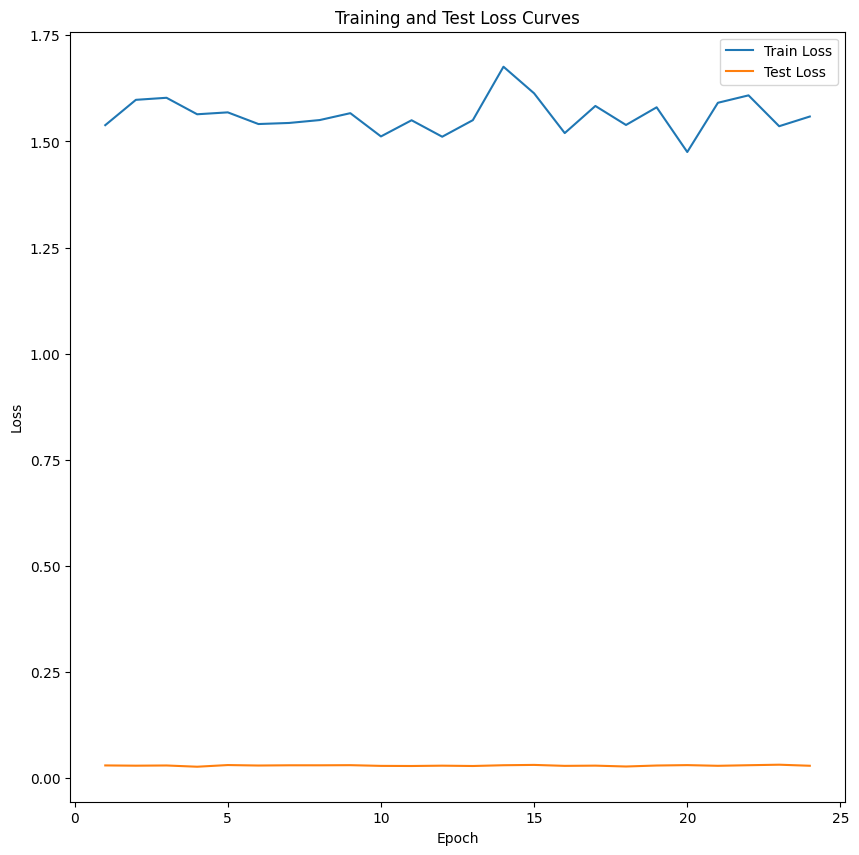

In [34]:
pretrain_agent(
    model,
   expert_observations,
    expert_actions,
    batch_size=64,
    epochs=1000,
    scheduler_gamma=0.95,
    learning_rate=3e-4,
    log_interval=20,
    no_cuda=False,
    seed=1,
    test_batch_size=64,
    early_stopping_patience=20,
    plot_curves=True,
)

Reward  0.04404766701551188


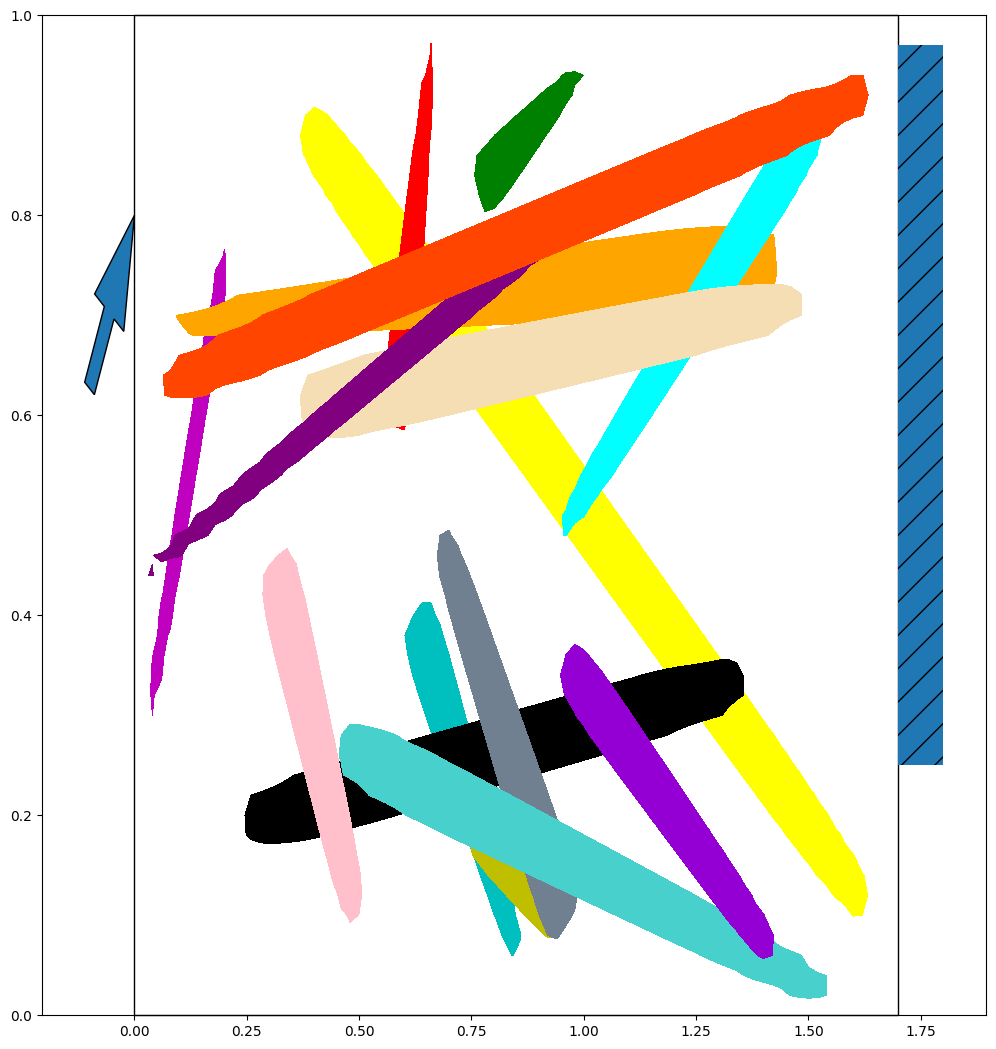

In [5]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done,truncated, info = train_env.step(action)
        
# print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [ ]:
from sogym.utils import profile_and_analyze
# Example usage
# Specify the number of episodes to run
num_episodes = 20
# Call the profile_and_analyze function
result_df = profile_and_analyze(num_episodes, train_env)
# Print the resulting DataFrame
result_df

---
### Multiprocessing

In [9]:
#from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
import multiprocessing

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')

# Set number of cpus to use automatically:
num_cpu = multiprocessing.cpu_count()
# num_cpu = 
print("Using {} cpus!".format(num_cpu))
observation_type = "image"

train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type = 'hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


Using 64 cpus!
Using: image observation space
Using: image observation space


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

--- 
### Defining the model

In [10]:
import yaml
from stable_baselines3 import SAC, TD3, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from sogym.utils import ImageDictExtractor, CustomBoxDense
from datetime import datetime


chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file


with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch']
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

In [4]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from sogym.callbacks import FigureRecorderCallback, MaxRewardCallback, GradientNormCallback
from stable_baselines3.common.callbacks import CheckpointCallback


# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=5000//num_cpu,
  save_path="./checkpoints/",
  name_prefix=tb_log_name,
  save_replay_buffer=True,
  save_vecnormalize=True,
)

eval_callback = EvalCallback(eval_env,
                             log_path='tb_logs',
                             eval_freq=5000//num_cpu,
                             deterministic=True,
                            n_eval_episodes=10,
                             render=False,
                             best_model_save_path='./checkpoints',
                             verbose=0)



callback_list = CallbackList([eval_callback,
                         checkpoint_callback,
                         MaxRewardCallback(verbose=1),
                         GradientNormCallback(verbose=1),
                         FigureRecorderCallback(check_freq=5000//num_cpu,eval_env=eval_env)
                         ])

--- 
### Training

Save the model:

If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

If the environment is normalized:
#env.save('env_saved.pkl')
#env = VecNormalize.load('env_saved.pkl',env)


In [5]:
#model = SAC.load("model_saved_march15",env =env) #Saved model is with soft volume constraint and 75 r
#model.set_parameters("model_saved_march15")
#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
model.learn(20000000,
            callback=callback_list, 
            tb_log_name=tb_log_name
            )
#model.save('model_saved_march15',)
#model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

2024-03-26 14:10:56.140944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 14:10:56.644911: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/cv2/../../lib64:/local/cuda-11.3/lib64:/local/TensorRT-7.2.2.3/lib
2024-03-26 14:10:56.645044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

KeyboardInterrupt: 

---
### Let's visualize the agent's performance:

In [15]:
env=sogym(mode='train',observation_type='image',vol_constraint_type='hard' ,resolution = 50)
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

Using: image observation space


<Figure size 1000x1000 with 0 Axes>

Desired volume: 0.39 Obtained volume: 0.03519981324594981
Env reward: 0.04185947257287557 Compliance: 23716938299.82084


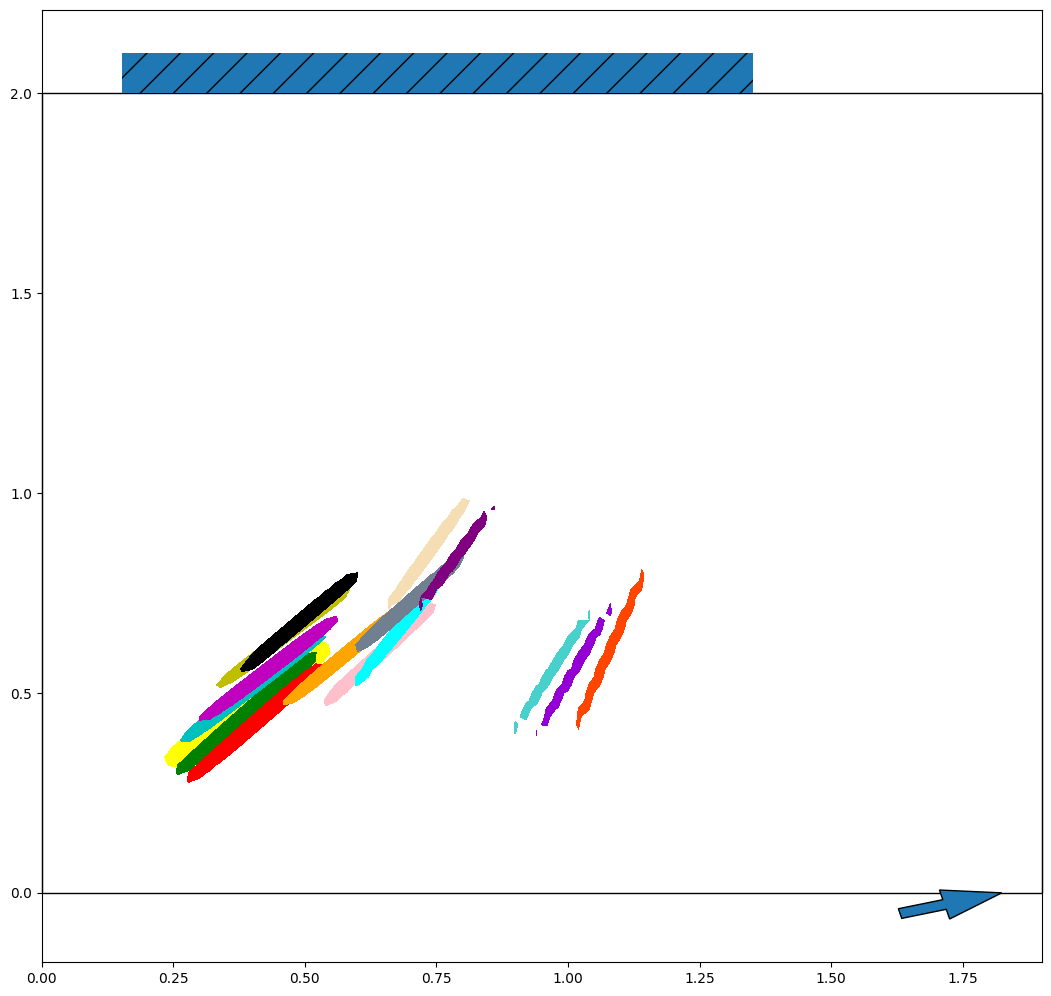

In [28]:
obs,info=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    # print(action)
    obs, rewards, dones,truncated, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
print("Env reward:",rewards, "Compliance:",np.exp(1/rewards))
env.plot()

In [ ]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')